# Imports

In [1]:
import datetime
import glob
import itertools
import json
import os
import pickle
import random
import re
from string import punctuation

In [2]:
import statistics

import fuzzywuzzy
import geopandas as gpd
import humanize
import missingno as msno
import numpy as np
import pandas as pd
import recordlinkage
import scipy as sp
import statsmodels.formula.api as smf
from pandas_profiling import ProfileReport

In [3]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
MAPBOX_STYLE = "dark"
MAPBOX_HEIGHT = 800
%matplotlib inline
import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from matplotlib.ticker import PercentFormatter

px.set_mapbox_access_token(os.getenv("MAPBOX_TOKEN"))
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
plt.style.use("seaborn-colorblind")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Open Sans"
plt.rcParams["figure.figsize"] = 15, 6
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
from sklearn import __version__ as sklearn_version
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (average_precision_score, classification_report,
                             confusion_matrix, mean_absolute_error,
                             mean_squared_error, plot_precision_recall_curve,
                             precision_recall_curve, r2_score, roc_auc_score,
                             roc_curve)
from sklearn.model_selection import (GridSearchCV, KFold, cross_val_score,
                                     cross_validate, learning_curve,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (LabelEncoder, MinMaxScaler, Normalizer,
                                   StandardScaler, normalize, scale)

# Grains

## Data

In [24]:
df = pd.read_csv('datasets/grains/seeds.csv', header=None)
varieties = pd.read_csv('datasets/grains/varieties.csv', header=None)
assert df.shape[0] == varieties.shape[0], "Data size mismatch"

In [25]:
print(df.shape)
df.sample(10)

(210, 8)


,0,1,2,3,4,5,6,7
171,11.55,13.10,0.8455,5.167,2.845,6.715,4.956,3
56,14.46,14.35,0.8818,5.388,3.377,2.802,5.044,1
186,11.81,13.45,0.8198,5.413,2.716,4.898,5.352,3
114,20.97,17.25,0.8859,6.563,3.991,4.677,6.316,2
28,14.11,14.18,0.8820,5.541,3.221,2.754,5.038,1
152,12.26,13.60,0.8333,5.408,2.833,4.756,5.360,3
88,21.18,17.21,0.8989,6.573,4.033,5.780,6.231,2
63,13.22,13.84,0.8680,5.395,3.070,4.157,5.088,1
60,11.42,12.86,0.8683,5.008,2.850,2.700,4.607,1
166,12.44,13.59,0.8462,5.319,2.897,4.924,5.270,3


In [26]:
print(varieties.shape)
varieties.sample(10)

(210, 1)


,0
176,Canadian_wheat
9,Kama_wheat
50,Kama_wheat
49,Kama_wheat
74,Rosa_wheat
161,Canadian_wheat
204,Canadian_wheat
18,Kama_wheat
28,Kama_wheat
103,Rosa_wheat


In [27]:
# reverse engineered:
#   variety -> 7
#   width   -> 4
#   length  -> 3
variety_numbers = df[7]
grains = df[[4, 3]].to_numpy()
samples = df.drop(7, axis=1).to_numpy()
varieties = varieties[0].to_list()

## KMeans Clustering

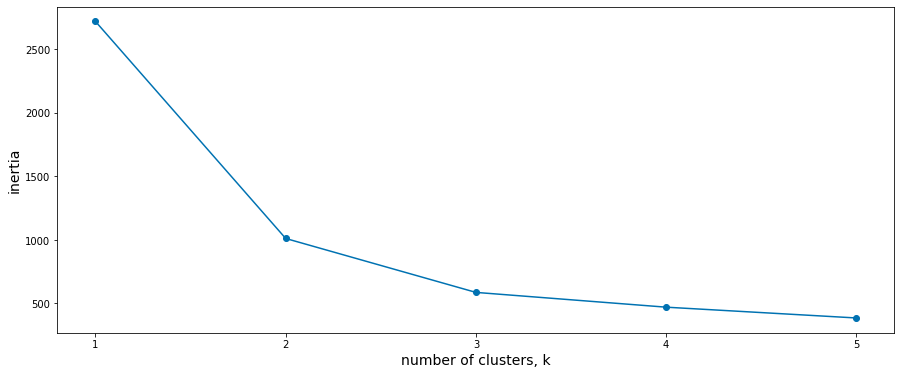

In [28]:
# How many clusters? Elbow of inertia
ks = range(1, 6)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(samples)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [29]:
# Create a KMeans model with 3 clusters: model
model = KMeans(n_clusters=3)

# Use fit_predict to fit model and obtain cluster labels: labels
labels = model.fit_predict(samples)

# Create a DataFrame with clusters and varieties as columns: df
df = pd.DataFrame({'labels': labels, 'varieties': varieties})

# Create crosstab: ct
ct = pd.crosstab(df['labels'], df['varieties'])

# Display ct
print(ct)

varieties  Canadian_wheat  Kama_wheat  Rosa_wheat
labels                                           
0                       2          60          10
1                       0           1          60
2                      68           9           0


## Hierarchical Clustering

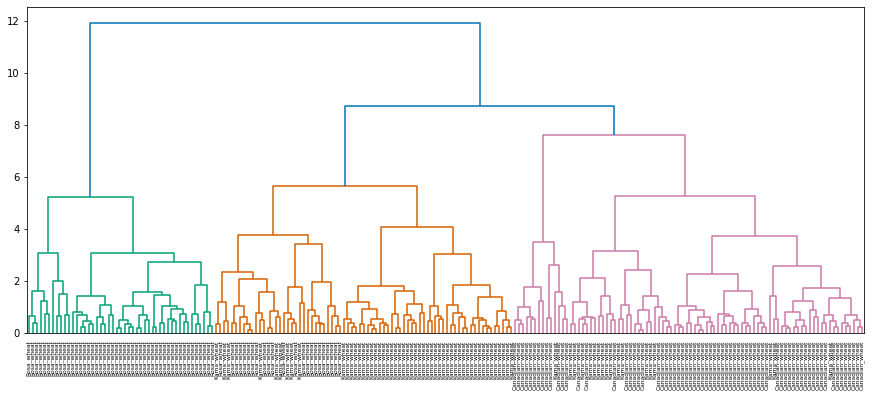

In [30]:
# Calculate the linkage: mergings
mergings = sp.cluster.hierarchy.linkage(samples, method='complete')

# Plot the dendrogram, using varieties as labels
sp.cluster.hierarchy.dendrogram(
    mergings,
    labels=varieties,
    leaf_rotation=90,
    leaf_font_size=6,
)
plt.show()

In [31]:
# Use fcluster to extract labels: labels
labels = sp.cluster.hierarchy.fcluster(mergings, 6, criterion='distance')

# Create a DataFrame with labels and varieties as columns: df
df = pd.DataFrame({'labels': labels, 'varieties': varieties})

# Create crosstab: ct
ct = pd.crosstab(df.labels, df.varieties)

# Display ct
print(ct)

varieties  Canadian_wheat  Kama_wheat  Rosa_wheat
labels                                           
1                       0           0          47
2                       0          52          23
3                      13           1           0
4                      57          17           0


## t-distributed Stochastic Neighbor Embedding (t-SNE)

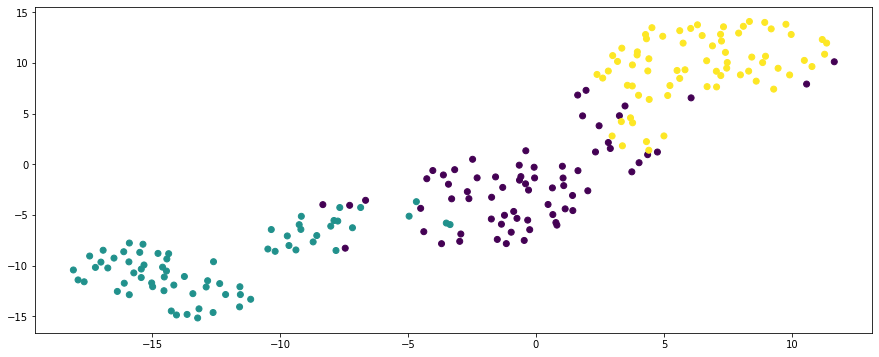

In [32]:
# Create a TSNE instance: model
model = TSNE(learning_rate=200)

# Apply fit_transform to samples: tsne_features
tsne_features = model.fit_transform(samples)

# Select the 0th feature: xs
xs = tsne_features[:,0]

# Select the 1st feature: ys
ys = tsne_features[:,1]

# Scatter plot, coloring by variety_numbers
plt.scatter(xs, ys, c=variety_numbers)
plt.show()

## PCA

Raw R2: 0.8604149377143469
PCA R2: 8.935982743022041e-17


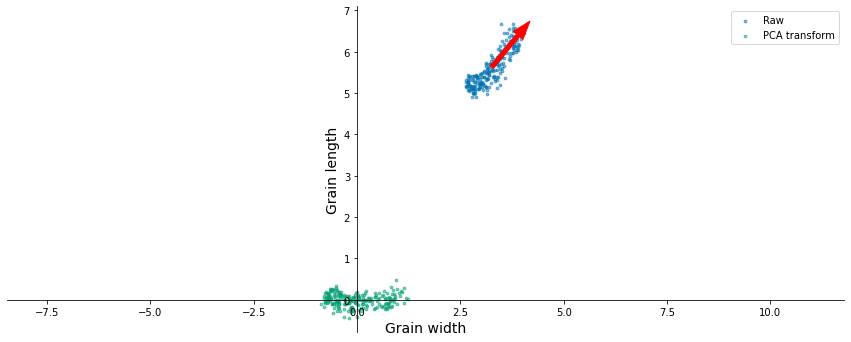

In [69]:
# Assign the 0th column of grains: width
width = grains[:, 0]
length = grains[:, 1]

# Create PCA instance: model
model = PCA()
pca_features = model.fit_transform(grains)
xs = pca_features[:,0]
ys = pca_features[:,1]

# Get the mean of the grain samples: mean
model_mean = model.mean_
first_pc = model.components_[0, :]

# Scatter plot xs vs ys
fig, ax = plt.subplots()
plt.scatter(width, length, label="Raw", alpha=0.5, s=8)
plt.scatter(xs, ys, label="PCA transform", alpha=0.5, s=8)
plt.arrow(model_mean[0], model_mean[1], first_pc[0], first_pc[1], color='red', width=0.1)
plt.xlabel('Grain width')
plt.ylabel('Grain length')
plt.legend()
plt.axis('equal')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')

# Calculate the Pearson correlation
correlation, pvalue = sp.stats.pearsonr(width, length)
pca_correlation, pvalue = sp.stats.pearsonr(xs, ys)
print("Raw R2:", correlation)
print("PCA R2:", pca_correlation)

# Wines

In [353]:
## Data

In [94]:
df = pd.read_csv('datasets/wine.csv')

In [95]:
df.sample(10)

,class_label,class_name,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280,proline
114,2,Grignolino,12.08,1.39,2.50,22.5,84,2.56,2.29,0.43,1.04,2.90,0.93,3.19,385
128,2,Grignolino,12.37,1.63,2.30,24.5,88,2.22,2.45,0.40,1.90,2.12,0.89,2.78,342
112,2,Grignolino,11.76,2.68,2.92,20.0,103,1.75,2.03,0.60,1.05,3.80,1.23,2.50,607
52,1,Barolo,13.82,1.75,2.42,14.0,111,3.88,3.74,0.32,1.87,7.05,1.01,3.26,1190
64,2,Grignolino,12.17,1.45,2.53,19.0,104,1.89,1.75,0.45,1.03,2.95,1.45,2.23,355
164,3,Barbera,13.78,2.76,2.30,22.0,90,1.35,0.68,0.41,1.03,9.58,0.70,1.68,615
65,2,Grignolino,12.37,1.21,2.56,18.1,98,2.42,2.65,0.37,2.08,4.60,1.19,2.30,678
168,3,Barbera,13.58,2.58,2.69,24.5,105,1.55,0.84,0.39,1.54,8.66,0.74,1.80,750
86,2,Grignolino,12.16,1.61,2.31,22.8,90,1.78,1.69,0.43,1.56,2.45,1.33,2.26,495
56,1,Barolo,14.22,1.70,2.30,16.3,118,3.20,3.00,0.26,2.03,6.38,0.94,3.31,970


## Scale

In [96]:
df.agg(np.var)

/home/kcavagnolo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/core/apply.py:169: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return getattr(obj, f)()


class_label                 0.600679
alcohol                     0.659062
malic_acid                  1.248015
ash                         0.075265
alcalinity_of_ash          11.152686
magnesium                 203.989335
total_phenols               0.391690
flavanoids                  0.997719
nonflavanoid_phenols        0.015489
proanthocyanins             0.327595
color_intensity             5.374449
hue                         0.052245
od280                       0.504086
proline                 99166.717355
dtype: float64

<AxesSubplot:>

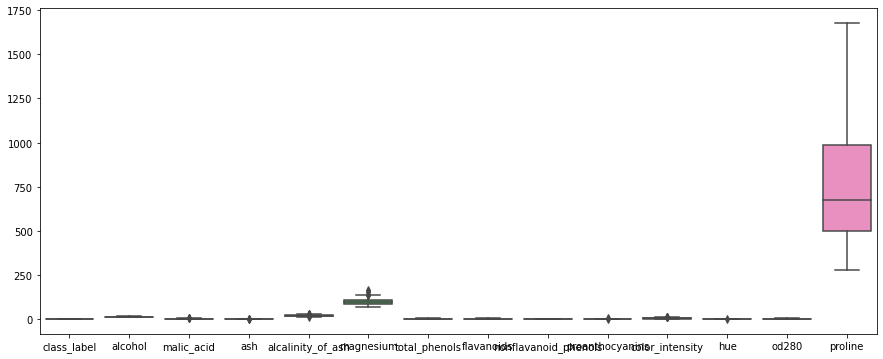

In [97]:
sns.boxplot(data=df)

In [98]:
samples = df.drop(["class_label", "class_name"], axis=1).to_numpy()

<AxesSubplot:>

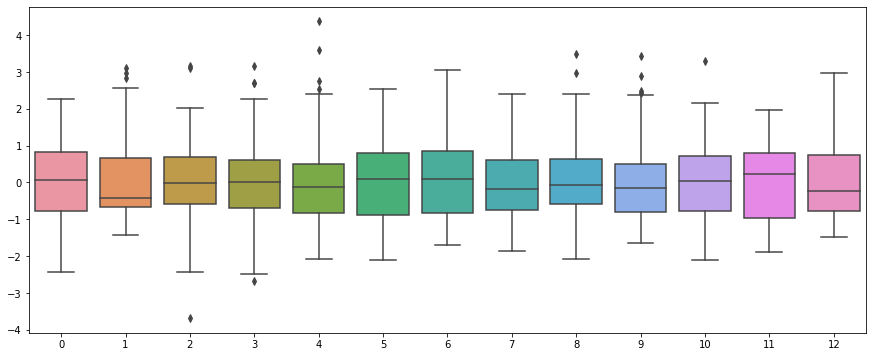

In [145]:
scaler = StandardScaler()
sns.boxplot(data=scaler.fit_transform(samples))

## KMeans Clustering

In [146]:
# build steps
scalar = StandardScaler()
model = KMeans()
pipeline = make_pipeline(scaler, model)

In [147]:
pipeline.fit(samples)

Pipeline(steps=[('standardscaler', StandardScaler()), ('kmeans', KMeans())])

In [148]:
# Setup the hyperparameter grid
k_space = [x for x in range(1, 15)]
param_grid = {f'{pipeline.steps[1][0]}__n_clusters': k_space}

# Instantiate the GridSearchCV object: logreg_cv
cv = KFold(n_splits=5)
model_cv = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1)

# Fit it to the data
model_cv.fit(samples)

# Print the tuned parameters and score
print("Tuned Parameters: {}".format(
    model_cv.best_params_))
print("Best score: {}".format(model_cv.best_score_))

Tuned Parameters: {'kmeans__n_clusters': 13}
Best score: -281.60050901417543


# Fish

## Data

In [91]:
df = pd.read_csv('datasets/fish.csv', header=None)

In [92]:
df.sample(10)

,0,1,2,3,4,5,6
49,Roach,200.0,22.1,23.5,26.8,27.6,15.4
15,Bream,700.0,30.4,33.0,38.3,38.8,13.8
72,Pike,430.0,35.5,38.0,40.5,18.0,11.3
52,Roach,272.0,25.0,27.0,30.6,28.0,15.6
29,Bream,920.0,35.0,38.5,44.1,40.9,14.3
21,Bream,620.0,31.5,34.5,39.7,39.1,13.3
71,Pike,300.0,34.8,37.3,39.8,15.8,10.1
2,Bream,340.0,23.9,26.5,31.1,39.8,15.1
82,Pike,1600.0,56.0,60.0,64.0,15.0,9.6
18,Bream,650.0,31.0,33.5,38.7,37.4,14.8


In [99]:
species = df[0]
df.drop(0, axis=1, inplace=True)
samples = df.to_numpy()

## KMeans Clustering

In [94]:
# pipeline
scaler = StandardScaler()
model = KMeans(n_clusters=4)
pipeline = make_pipeline(scaler, model)

In [95]:
# Fit the pipeline to samples
pipeline.fit(samples)

# Calculate the cluster labels: labels
labels = pipeline.predict(samples)

# Create a DataFrame with labels and species as columns: df
df_ct = pd.DataFrame({"labels": labels, "species": species})

# Create crosstab: ct
ct = pd.crosstab(df_ct.labels, df_ct.species)

# Display ct
print(ct)

species  Bream  Pike  Roach  Smelt
labels                            
0            1     0     19      1
1           33     0      1      0
2            0     0      0     13
3            0    17      0      0


## Intrinsic Dimensions

([<matplotlib.axis.XTick at 0x7ff9cf832850>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

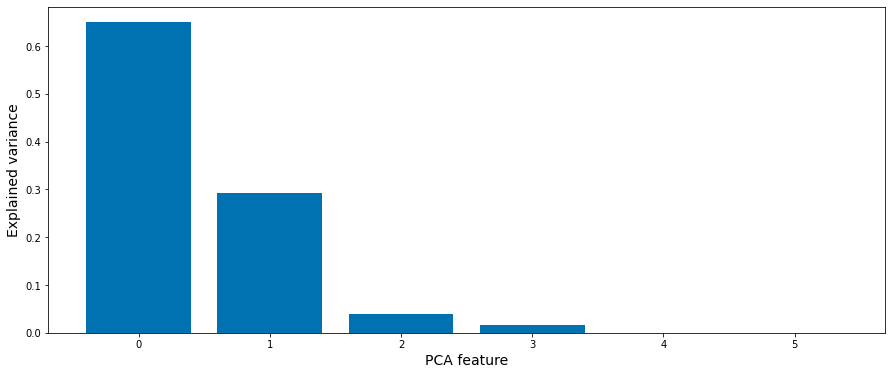

In [96]:
# Create pipeline: pipeline
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)

# Fit the pipeline to 'samples'
pipeline.fit(samples)

# Plot the explained variances
features = range(0, pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA feature')
plt.ylabel('Explained variance')
plt.xticks(features)

In [104]:
# component loadings or weights (correlation coefficient between original variables and the component)
# component loadings represents the elements of the eigenvector
# the squared loadings within the PCs always sums to 1
loadings = pca.components_
num_pc = pca.n_features_
pc_list = ["PC" + str(i) for i in list(range(1, num_pc + 1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['feature'] = df.columns.values
loadings_df = loadings_df.set_index('feature')
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6
feature,,,,,,
1,0.482436,-0.022969,-0.330179,0.810968,0.000248,0.006311
2,0.496622,0.120741,0.174025,-0.225946,-0.504754,0.634568
3,0.498907,0.101658,0.158914,-0.223189,-0.289235,-0.762911
4,0.503418,0.038466,0.085967,-0.264596,0.807748,0.123417
5,0.127925,-0.687801,-0.617391,-0.346926,-0.095052,0.000933
6,0.043808,-0.707113,0.668492,0.226047,0.008619,0.004274


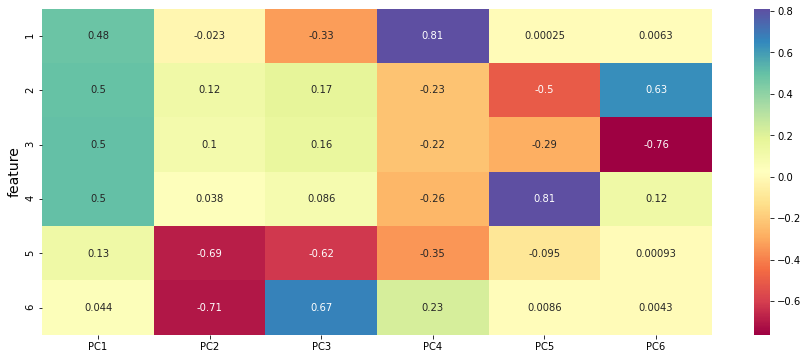

In [105]:
ax = sns.heatmap(loadings_df, annot=True, cmap='Spectral')

# Stocks

## Data

In [332]:
df = pd.read_csv('datasets/company-stock-movements-2010-2015-incl.csv')

In [333]:
df.sample(10)

,Unnamed: 0,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-11,2010-01-12,2010-01-13,2010-01-14,...,2013-10-16,2013-10-17,2013-10-18,2013-10-21,2013-10-22,2013-10-23,2013-10-24,2013-10-25,2013-10-28,2013-10-29
55,Wells Fargo,0.300000,0.800000,0.080000,1.009998,-0.039999,-0.290001,-0.389999,0.590000,0.490000,...,0.299999,0.639999,-0.040001,-0.020000,0.189999,-0.150002,-0.240001,0.220002,0.000000,-0.049999
48,Toyota,0.330002,0.599999,0.489998,0.680000,1.260002,0.070000,0.070000,0.200004,1.410003,...,0.740005,0.650009,0.520004,0.010010,-1.819992,-0.009995,0.220001,-0.119996,-0.630005,0.449997
40,Procter Gamble,0.009998,0.009998,-0.090001,-0.060002,0.079998,0.119999,0.189998,0.479999,0.160004,...,0.989998,1.229996,0.020005,-0.299996,1.069999,0.570008,-0.159996,-0.550003,1.190002,1.000000
4,Boeing,0.459999,1.770000,1.549999,2.690003,0.059997,-1.080002,0.360000,0.549999,0.530002,...,1.559997,2.480003,0.019997,-1.220001,0.480003,3.020004,-0.029999,1.940002,1.130005,0.309998
23,IBM,1.270004,-0.829987,-0.679993,-0.319992,1.779999,-1.580002,1.479996,-0.160003,1.759995,...,1.309998,0.990006,-1.020004,-1.559997,1.619995,0.680008,1.370010,-1.579987,0.310013,4.500000
37,Novartis,-1.139999,-0.050000,-0.500000,0.029999,-0.079998,0.180000,0.360000,-0.020001,0.410000,...,0.450004,0.150002,0.479996,0.490005,1.010002,0.300003,-0.310006,-0.240006,0.050003,-0.239997
20,Home Depot,-0.480000,0.149999,-0.099998,0.260000,-0.020000,-0.840000,-0.170000,0.129999,0.179998,...,-0.500000,1.229996,-0.570000,0.020005,-0.180000,0.540001,1.360001,-0.300003,-0.090004,1.050003
45,Sony,0.500000,0.160000,-0.029999,0.059999,0.369999,-0.119999,0.100001,0.380001,0.140000,...,0.130001,0.280001,-0.260000,0.010000,0.020001,-0.149999,-0.060002,0.010000,0.010000,-0.030000
31,McDonalds,0.149998,-0.360001,-0.750000,0.650002,-0.430000,0.300000,0.630001,-0.270001,0.090001,...,0.919998,0.279999,-0.500000,0.889999,0.440003,-0.870003,0.269996,0.000000,0.680001,0.430000
22,HP,0.910002,0.530000,-0.349997,0.010000,0.489999,-0.149998,-0.060001,0.020001,0.279996,...,0.350001,0.259999,-0.050000,0.030001,0.470001,-0.079999,0.100000,-0.080002,-0.130000,-0.120002


In [334]:
companies = df["Unnamed: 0"].to_list()
movements = df.drop("Unnamed: 0", axis=1).to_numpy()

## Normalize

In [335]:
# Create a normalizer: normalizer
normalizer = Normalizer()

# Create a KMeans model with 10 clusters: kmeans
kmeans = KMeans(n_clusters=10)

# Make a pipeline chaining normalizer and kmeans: pipeline
pipeline = make_pipeline(normalizer, kmeans)

# Fit pipeline to the daily price movements
pipeline.fit(movements)

Pipeline(steps=[('normalizer', Normalizer()),
                ('kmeans', KMeans(n_clusters=10))])

In [336]:
# Predict the cluster labels: labels
labels = pipeline.predict(movements)

# Create a DataFrame aligning labels and companies: df
df = pd.DataFrame({'labels': labels, 'companies': companies})

# Display df sorted by cluster label
print(df.sort_values(by=["labels"]))

    labels                           companies
59       0                               Yahoo
15       0                                Ford
35       0                            Navistar
1        0                                 AIG
57       1                               Exxon
53       1                       Valero Energy
44       1                        Schlumberger
42       1                   Royal Dutch Shell
8        1                         Caterpillar
58       1                               Xerox
10       1                      ConocoPhillips
32       1                                  3M
12       1                             Chevron
13       1                   DuPont de Nemours
31       1                           McDonalds
16       1                   General Electrics
2        1                              Amazon
23       1                                 IBM
36       2                    Northrop Grumman
29       2                     Lookheed Martin
4        2   

## Hierarchical Clustering

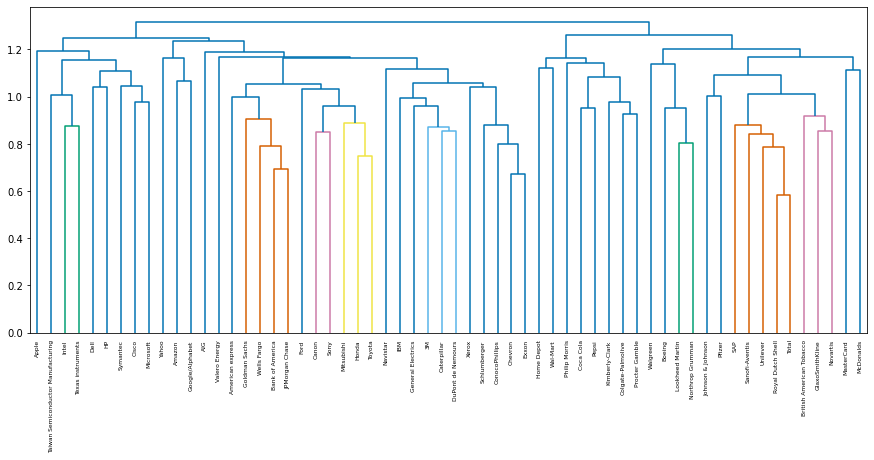

In [337]:
# Normalize the movements: normalized_movements
normalized_movements = normalize(movements)

# Calculate the linkage: mergings
mergings = sp.cluster.hierarchy.linkage(normalized_movements,
                                        method='complete')

# Plot the dendrogram
_ = sp.cluster.hierarchy.dendrogram(mergings,
                                    labels=companies,
                                    leaf_rotation=90,
                                    leaf_font_size=6)

/home/kcavagnolo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


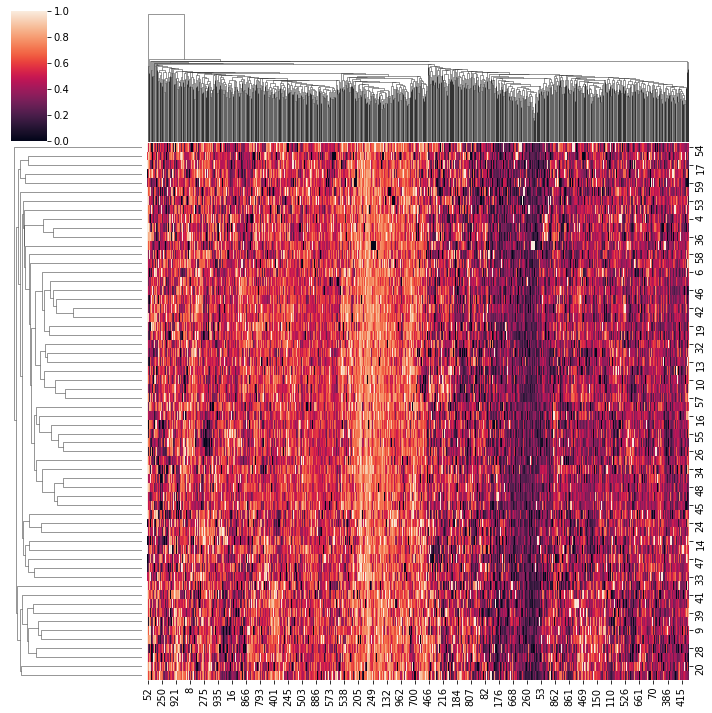

In [338]:
sns.clustermap(normalized_movements, standard_scale=1)

## t-SNE

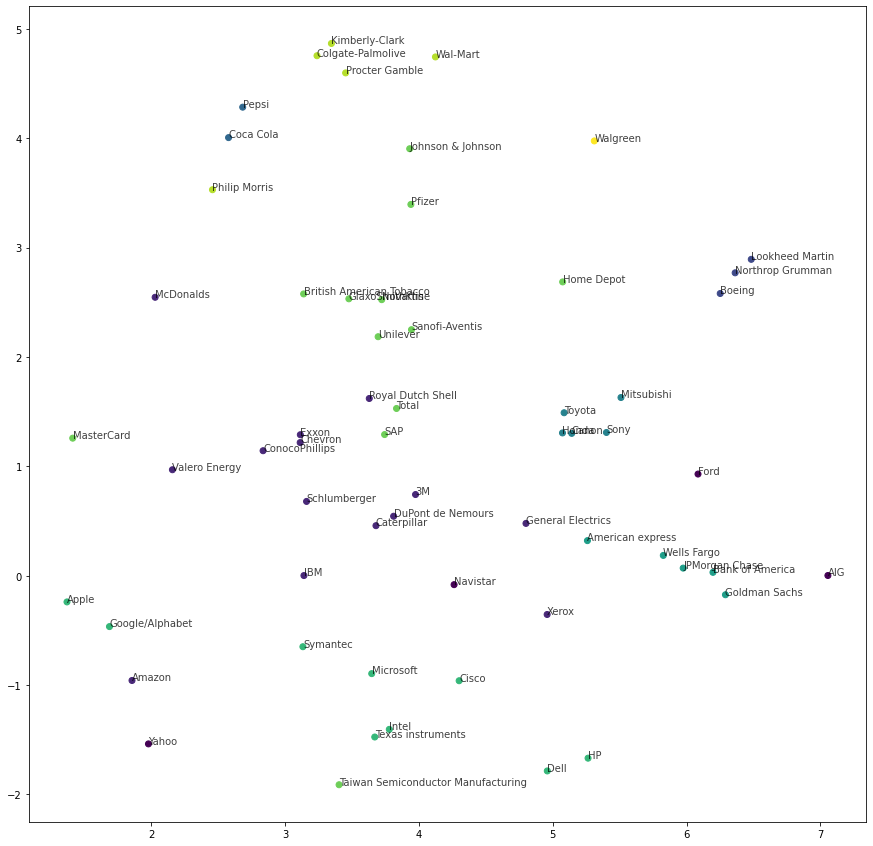

In [350]:
# Create a TSNE instance: model
model = TSNE(learning_rate=50)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_movements)

# Select the 0th feature: xs
xs = tsne_features[:, 0]

# Select the 1th feature: ys
ys = tsne_features[:, 1]

# Scatter plot
fig, ax = plt.subplots(figsize=(15, 15))
plt.scatter(xs, ys, c=labels)

# Annotate the points
for x, y, company in zip(xs, ys, companies):
    plt.annotate(company, (x, y), fontsize=10, alpha=0.75)

# Eurovision

## Data

In [276]:
df = pd.read_csv('datasets/eurovision-2016.csv')

In [277]:
df.head(10)

,From country,To country,Jury A,Jury B,Jury C,Jury D,Jury E,Jury Rank,Televote Rank,Jury Points,Televote Points
0,Albania,Belgium,20,16,24,22,24,25,14,NaN,NaN
1,Albania,Czech Republic,21,15,25,23,16,22,22,NaN,NaN
2,Albania,The Netherlands,22,14,23,24,21,24,24,NaN,NaN
3,Albania,Azerbaijan,19,12,11,21,11,13,19,NaN,NaN
4,Albania,Hungary,8,13,9,14,9,10,10,1.0,1.0
5,Albania,Italy,4,10,3,7,2,3,2,8.0,10.0
6,Albania,Israel,10,2,18,4,12,8,17,3.0,NaN
7,Albania,Bulgaria,11,3,6,13,6,7,3,4.0,8.0
8,Albania,Sweden,16,8,15,6,15,11,8,NaN,3.0
9,Albania,Germany,18,17,20,11,17,18,15,NaN,NaN


In [278]:
df.columns = [x.lower().replace(" ","_") for x in df.columns]
df.fillna(0, inplace=True)

In [279]:
df.head()

,from_country,to_country,jury_a,jury_b,jury_c,jury_d,jury_e,jury_rank,televote_rank,jury_points,televote_points
0,Albania,Belgium,20,16,24,22,24,25,14,0.0,0.0
1,Albania,Czech Republic,21,15,25,23,16,22,22,0.0,0.0
2,Albania,The Netherlands,22,14,23,24,21,24,24,0.0,0.0
3,Albania,Azerbaijan,19,12,11,21,11,13,19,0.0,0.0
4,Albania,Hungary,8,13,9,14,9,10,10,1.0,1.0


In [286]:
# reconstructing the samples used in DC tutorial
samples = df.pivot_table(index="from_country",
                         columns="to_country",
                         values="televote_points").fillna(
                             max(df.televote_points)).to_numpy()

In [287]:
country_names = df.from_country.unique()

## Hierarchical Clustering

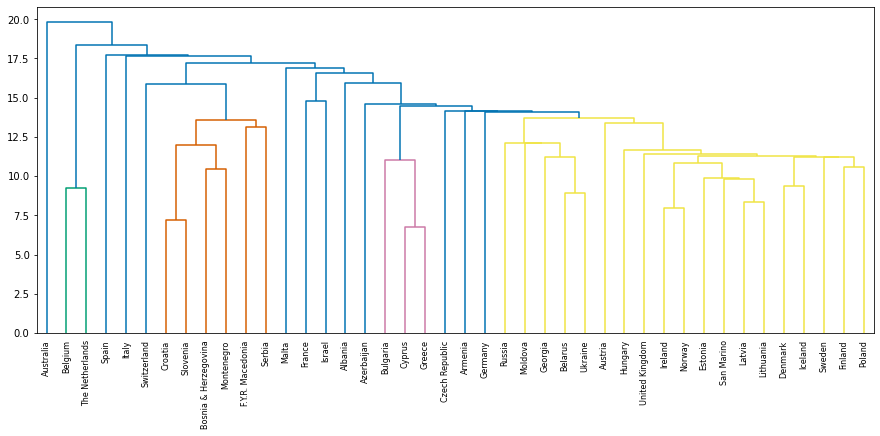

In [289]:
# Calculate the linkage: mergings
mergings = sp.cluster.hierarchy.linkage(samples, method='single')

# Plot the dendrogram
sp.cluster.hierarchy.dendrogram(mergings, labels=country_names, leaf_rotation=90)
plt.show()

# Wikipedia

In [107]:
df=pd.read_csv('datasets/wikipedia_articles/wikipedia-vectors.csv')

In [109]:
df.sample(10)

,Unnamed: 0,HTTP 404,Alexa Internet,Internet Explorer,HTTP cookie,Google Search,Tumblr,Hypertext Transfer Protocol,Social search,Firefox,...,Chad Kroeger,Nate Ruess,The Wanted,Stevie Nicks,Arctic Monkeys,Black Sabbath,Skrillex,Red Hot Chili Peppers,Sepsis,Adam Levine
7124,7124,0.0,0.0,0.004602,0.000000,0.008966,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.004001,0.001836,0.000000,0.00000,0.002461,0.000000
2222,2222,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.012294,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2583,2583,0.0,0.0,0.000000,0.006878,0.004147,0.0,0.005751,0.0,0.008810,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.010245,0.000000
1900,1900,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
9986,9986,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2018,2018,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
9537,9537,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.038097
8985,8985,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
6792,6792,0.0,0.0,0.000000,0.004557,0.004121,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.004702,0.000000,0.002531,0.039325,0.00526,0.006787,0.000000
4137,4137,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


In [110]:
df.columns = [x.lower().replace(" ","_") for x in df.columns]

In [111]:
df

,unnamed:_0,http_404,alexa_internet,internet_explorer,http_cookie,google_search,tumblr,hypertext_transfer_protocol,social_search,firefox,...,chad_kroeger,nate_ruess,the_wanted,stevie_nicks,arctic_monkeys,black_sabbath,skrillex,red_hot_chili_peppers,sepsis,adam_levine
0,0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.008878,0.0,0.0,0.049502,0.000000,0.000000,0.0
1,1,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.006110,0.0
2,2,0.0,0.029607,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
3,3,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.005646,0.000000,0.0
4,4,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13120,13120,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
13121,13121,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
13122,13122,0.0,0.000000,0.011594,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
13123,13123,0.0,0.000000,0.000000,0.0,0.006649,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.005476,0.0
